torch.Size([128, 1, 28, 28]) torch.Size([128])


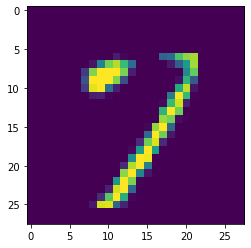

In [75]:
import torch
from torchvision import datasets
import tqdm
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

train_loader = DataLoader(training_data, shuffle = True, batch_size = 128)
test_loader = DataLoader(test_data, shuffle = False, batch_size = 128)
for i in train_loader:
    print(i[0].shape, i[1].shape)
    plt.imshow(i[0][0].squeeze(0))
    break

In [68]:
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
class MSA101(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA101, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA101(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

class ViT101(nn.Module):
    def __init__(self, chw = (1,28,28), patch_size = 4, hidden_d = 8, n_blocks=2, n_heads=2, out_d=10):
        super(ViT101, self).__init__()
        self.chw = chw
        self.hidden_d = hidden_d
        self.patch_size = patch_size
        self.input_d = chw[0] * patch_size * patch_size
    
        assert chw[1]==chw[2], 'please square img'
        assert chw[1] % patch_size == 0 and chw[2] % patch_size == 0, 'h and w should be divisible by patch_size'

        num_patches = (self.chw[1] // self.patch_size) * (self.chw[2] // self.patch_size)
        # patchify
        self.to_patch = nn.Sequential(Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size))    
        # linear mapping
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        # classification tokens
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.hidden_d))
        # position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, self.hidden_d))
        # create meat
        self.blocks = nn.ModuleList([ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        # classificate
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.to_patch(x)
        b, n, _ = x.shape
        x = self.linear_mapper(x)
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        for block in self.blocks:
            out = block(x)
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) 

torch.Size([128, 10])


In [74]:
model = ViT101()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
epochs = 5
for epoch in range(1,epochs+1):
    train_loss = 0
    model.train()
    for (images, labels) in train_loader:
        images, labels = images.to(device), labels.to(device)
        p_labels = model(images)
        loss = criterion(p_labels, labels)
        train_loss += loss.detach().cpu().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print (f'epoch: {epoch} train loss: {train_loss/len(train_loader)}')

    test_loss = 0
    model.eval()
    correct = 0
    with torch.no_grad():
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            p_labels = model(images)
            loss = criterion(p_labels, labels)
            test_loss += loss.detach().cpu().item()
            pred = p_labels.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()
    print (f'epoch: {epoch} test loss: {test_loss/len(test_loader)} accuracy: {correct/len(test_loader)}')

epoch: 1 train loss: 2.1768749299079877
epoch: 1 test loss: 2.036287153823466 accuracy: 54.43037974683544
epoch: 2 train loss: 1.9646807049891588
epoch: 2 test loss: 1.8766154790226417 accuracy: 75.78481012658227
epoch: 3 train loss: 1.8468450229051017
epoch: 3 test loss: 1.8013120587868026 accuracy: 83.9873417721519
epoch: 4 train loss: 1.8045040973976476
epoch: 4 test loss: 1.7768752152406717 accuracy: 87.0379746835443
epoch: 5 train loss: 1.781542129862283
epoch: 5 test loss: 1.7602002560337888 accuracy: 89.0253164556962
